# Gaussian Process for Event likelihoods

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions

## Creating some random data

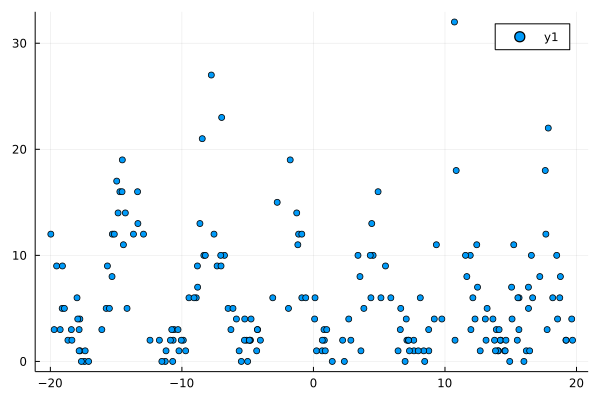

In [2]:
n_data = 200
X = (rand(n_data) .- 0.5) * 40
r = 5.0
Y = rand.(NegativeBinomial.(r, AGP.logistic.(sin.(X))))
scatter(X, Y)

## Run GP model with negative binomial likelihood to learn p

In [3]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_negbinomial = VGP(
    X, Y, kernel, NegBinomialLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_negbinomial, 20)

[ Info: Starting training Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:03
  iter:  20
  ELBO:  -517.7027123277165
[ Info: Training ended after 20 iterations. Total number of iterations 20
  4.004071 seconds (6.81 M allocations: 414.225 MiB, 2.19% gc time, 98.23% compilation time)


(Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference , (local_vars = (c = [0.4283304050513461, 0.19648543639294966, 0.5073499129083594, 0.3285266306559519, 0.18235520033255034, 0.22385215502555675, 0.458278513774611, 0.17914578432697745, 0.4900812328541448, 0.4870147409534296  …  0.3046424347948667, 0.48073698581022484, 0.17897365773573795, 0.3284074520576335, 0.4707687647775351, 0.17868539339686662, 0.3622545725759244, 0.28876073999305674, 0.4990615901763622, 0.24129642903501972], θ = [3.447452669990516, 2.491987904099556, 7.34315847025543, 2.973305637838552, 6.48204742740674, 4.4813025168631455, 13.26858730284321, 4.986670604992004, 2.451135862544859, 2.9420775966413357  …  5.954023143835348, 3.4341157067566916, 6.981374575290377, 6.9377578559923245, 3.9277269080825197, 5.984086572302316, 3.462220750799715, 3.4758811168579538, 9.307615698120172, 4.975880437820234]), opt_state = (NamedTuple(),), hyperopt_state = (NamedTu

## Running the same model but with a Poisson likelihood

In [4]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_poisson = VGP(
    X, Y, kernel, PoissonLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_poisson, 20)

[ Info: Starting training Variational Gaussian Process with a Poisson Likelihood (λ = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:01
  iter:  20
  ELBO:  -670.8753338984573
[ Info: Training ended after 20 iterations. Total number of iterations 20
  2.662468 seconds (4.34 M allocations: 302.817 MiB, 2.56% gc time, 96.13% compilation time)


(Variational Gaussian Process with a Poisson Likelihood (λ = 12.819208740882235) infered by Analytic Variational Inference , (local_vars = (c = [0.5645783209054864, 0.3216448214125475, 0.5154585776500963, 0.48602925862454566, 0.2106778304583978, 0.29375558209660607, 0.44808889111173705, 0.21157243308409715, 0.6747434724865677, 0.6761856272756409  …  0.24429017391300512, 0.6642326287862518, 0.21558181396711049, 0.270835929264432, 0.6496701567170847, 0.2789365371992261, 0.5301214056264459, 0.43431174929052274, 0.5004018985966785, 0.3541357348546334], θ = [4.821076368800094, 3.608368966094533, 7.259926582621431, 4.310085559993319, 7.3650390257005265, 5.493712648455006, 13.307247934997566, 5.882419543058647, 4.059084438972944, 4.5457125070569075  …  6.346580367532589, 5.0136964682281695, 7.883686222018333, 7.373630505654804, 5.474886748324541, 7.020228814759876, 4.874510277428598, 4.729810631228828, 9.244479378980833, 6.107975449137722], γ = [7.896920979357731, 7.278848453893913, 4.8399292

Prediction and plot function on a grid
Create a grid and compute prediction on it

In [5]:
function compute_grid(model, n_grid=50)
    mins = -20
    maxs = 20
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, reshape(x_grid, :, 1)) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end

compute_grid (generic function with 2 methods)

Plot the data as a scatter plot

In [6]:
function plot_data(X, Y)
    return Plots.scatter(X, Y; alpha=0.33, msw=0.0, lab="", size=(800, 500))
end

function plot_model(model, X, Y, title=nothing)
    n_grid = 100
    y_grid, sig_y_grid, x_grid = compute_grid(model, n_grid)
    p = plot_data(X, Y)
    Plots.plot!(
        p,
        x_grid,
        y_grid;
        ribbon=2 * sqrt.(sig_y_grid), # Plot 2 std deviations
        title=title,
        color="red",
        lab="",
        linewidth=3.0,
    )
    return p
end;

## Comparison between the two likelihoods

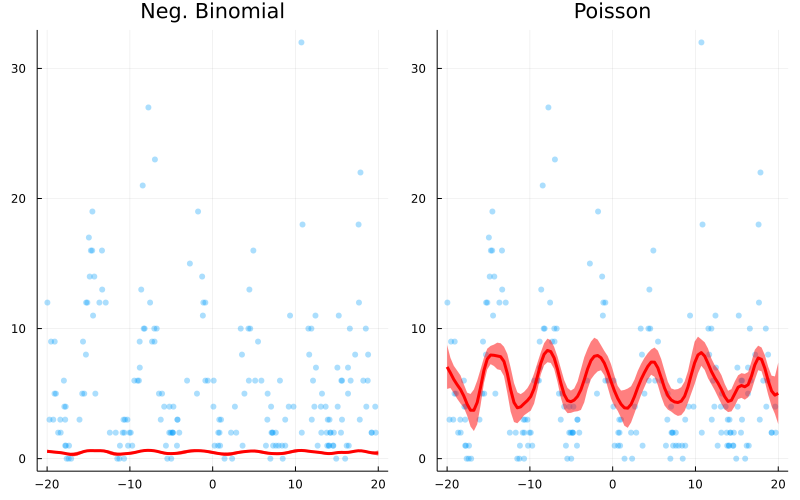

In [7]:
Plots.plot(
    plot_model.(
        [m_negbinomial, m_poisson], Ref(X), Ref(Y), ["Neg. Binomial", "Poisson"]
    )...;
    layout=(1, 2),
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*